In [1]:
import platform
import datetime as datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import query, mask_print_session, load_cached_json

if not platform.python_version().startswith('3'):
    raise Exception('Please execute with Python 3.x')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Collecting Data
Data is queried from OpenTSDB, which is hosed on http://il075:9999 (only reachable within the SRFG network). <br/>
Documentation about the REST query can be found on http://opentsdb.net/docs/build/html/api_http/query/index.html.

## Measurements

| SensorID              | Unit | Description                                                                               |
|-----------------------|------|-------------------------------------------------------------------------------------------|
| fila.distance         | mm   | mength of filament                                                                        |
| file.skidrate         | 1/m  | skids per meter                                                                           |
| fila.skidcount        | 1    | absolute number of skids                                                                  |
| temp                  | C°   | temperature of sorounding                                                                 |
| temp.bed.current      | C°   | temperature of bottom plateau                                                             |
| temp.nozzle.currentC° | C°   | temperature of nozzle                                                                     |
| airquality            | VOC  | quality of air http://www.velux.de/produkte/lueftungsloesungen-belueftung/raumluftfuehler |
| head.pos.z            | mm   | z-coordinate of printerhead                                                               |
| extrusion             | mm3  | volume of used filament                                                                   |

In [2]:
# df = query(host='http://il075:9999/api/query',
#            start=datetime.date(year=2016, month=12, day=23),
#            end=datetime.date(year=2016, month=12, day=24),
#            metric=['avg:fila.distance',
#                    'avg:fila.skidrate',
#                    'avg:fila.skidcount',
#                    'avg:temp',
#                    'avg:temp.bed.current',
#                    'avg:temp.nozzle.current',
#                    'avg:airquality',
#                    'avg:head.pos.z',
#                    'avg:extrusion'])

df = load_cached_json()

df.head()

,fila.distance,fila.skidrate,fila.skidcount,temp,temp.bed.current,temp.nozzle.current,airquality,head.pos.z,extrusion
2016-12-23 09:55:34,3.2,NaN,NaN,27.346001,NaN,NaN,NaN,NaN,NaN
2016-12-23 09:55:35,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-23 09:55:36,12.8,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-23 09:55:37,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-23 09:55:38,17.6,NaN,NaN,NaN,NaN,NaN,666.0,NaN,NaN


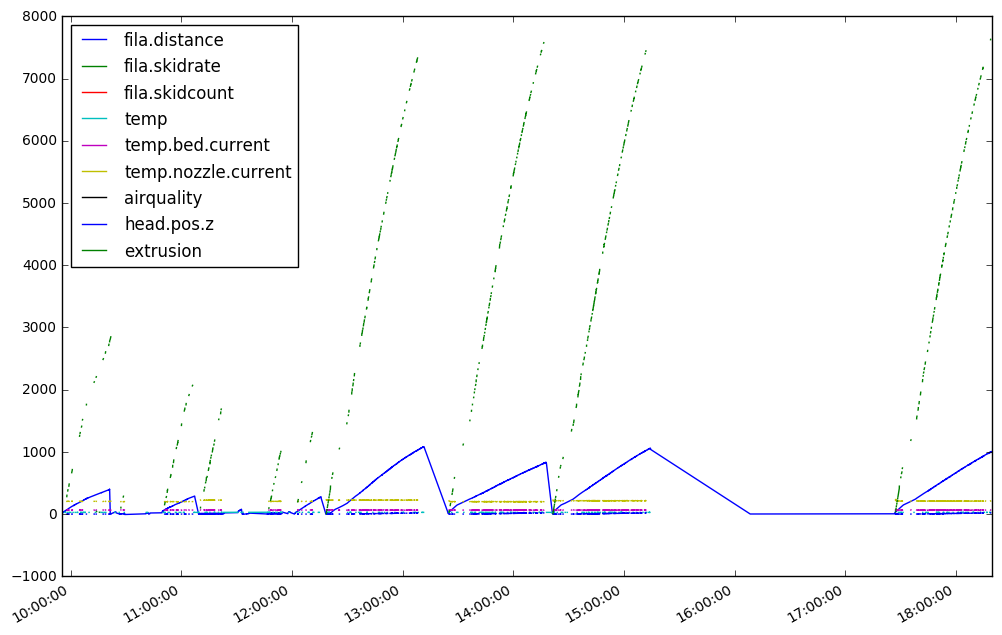

In [3]:
df.plot(figsize=(12, 8))
plt.show()

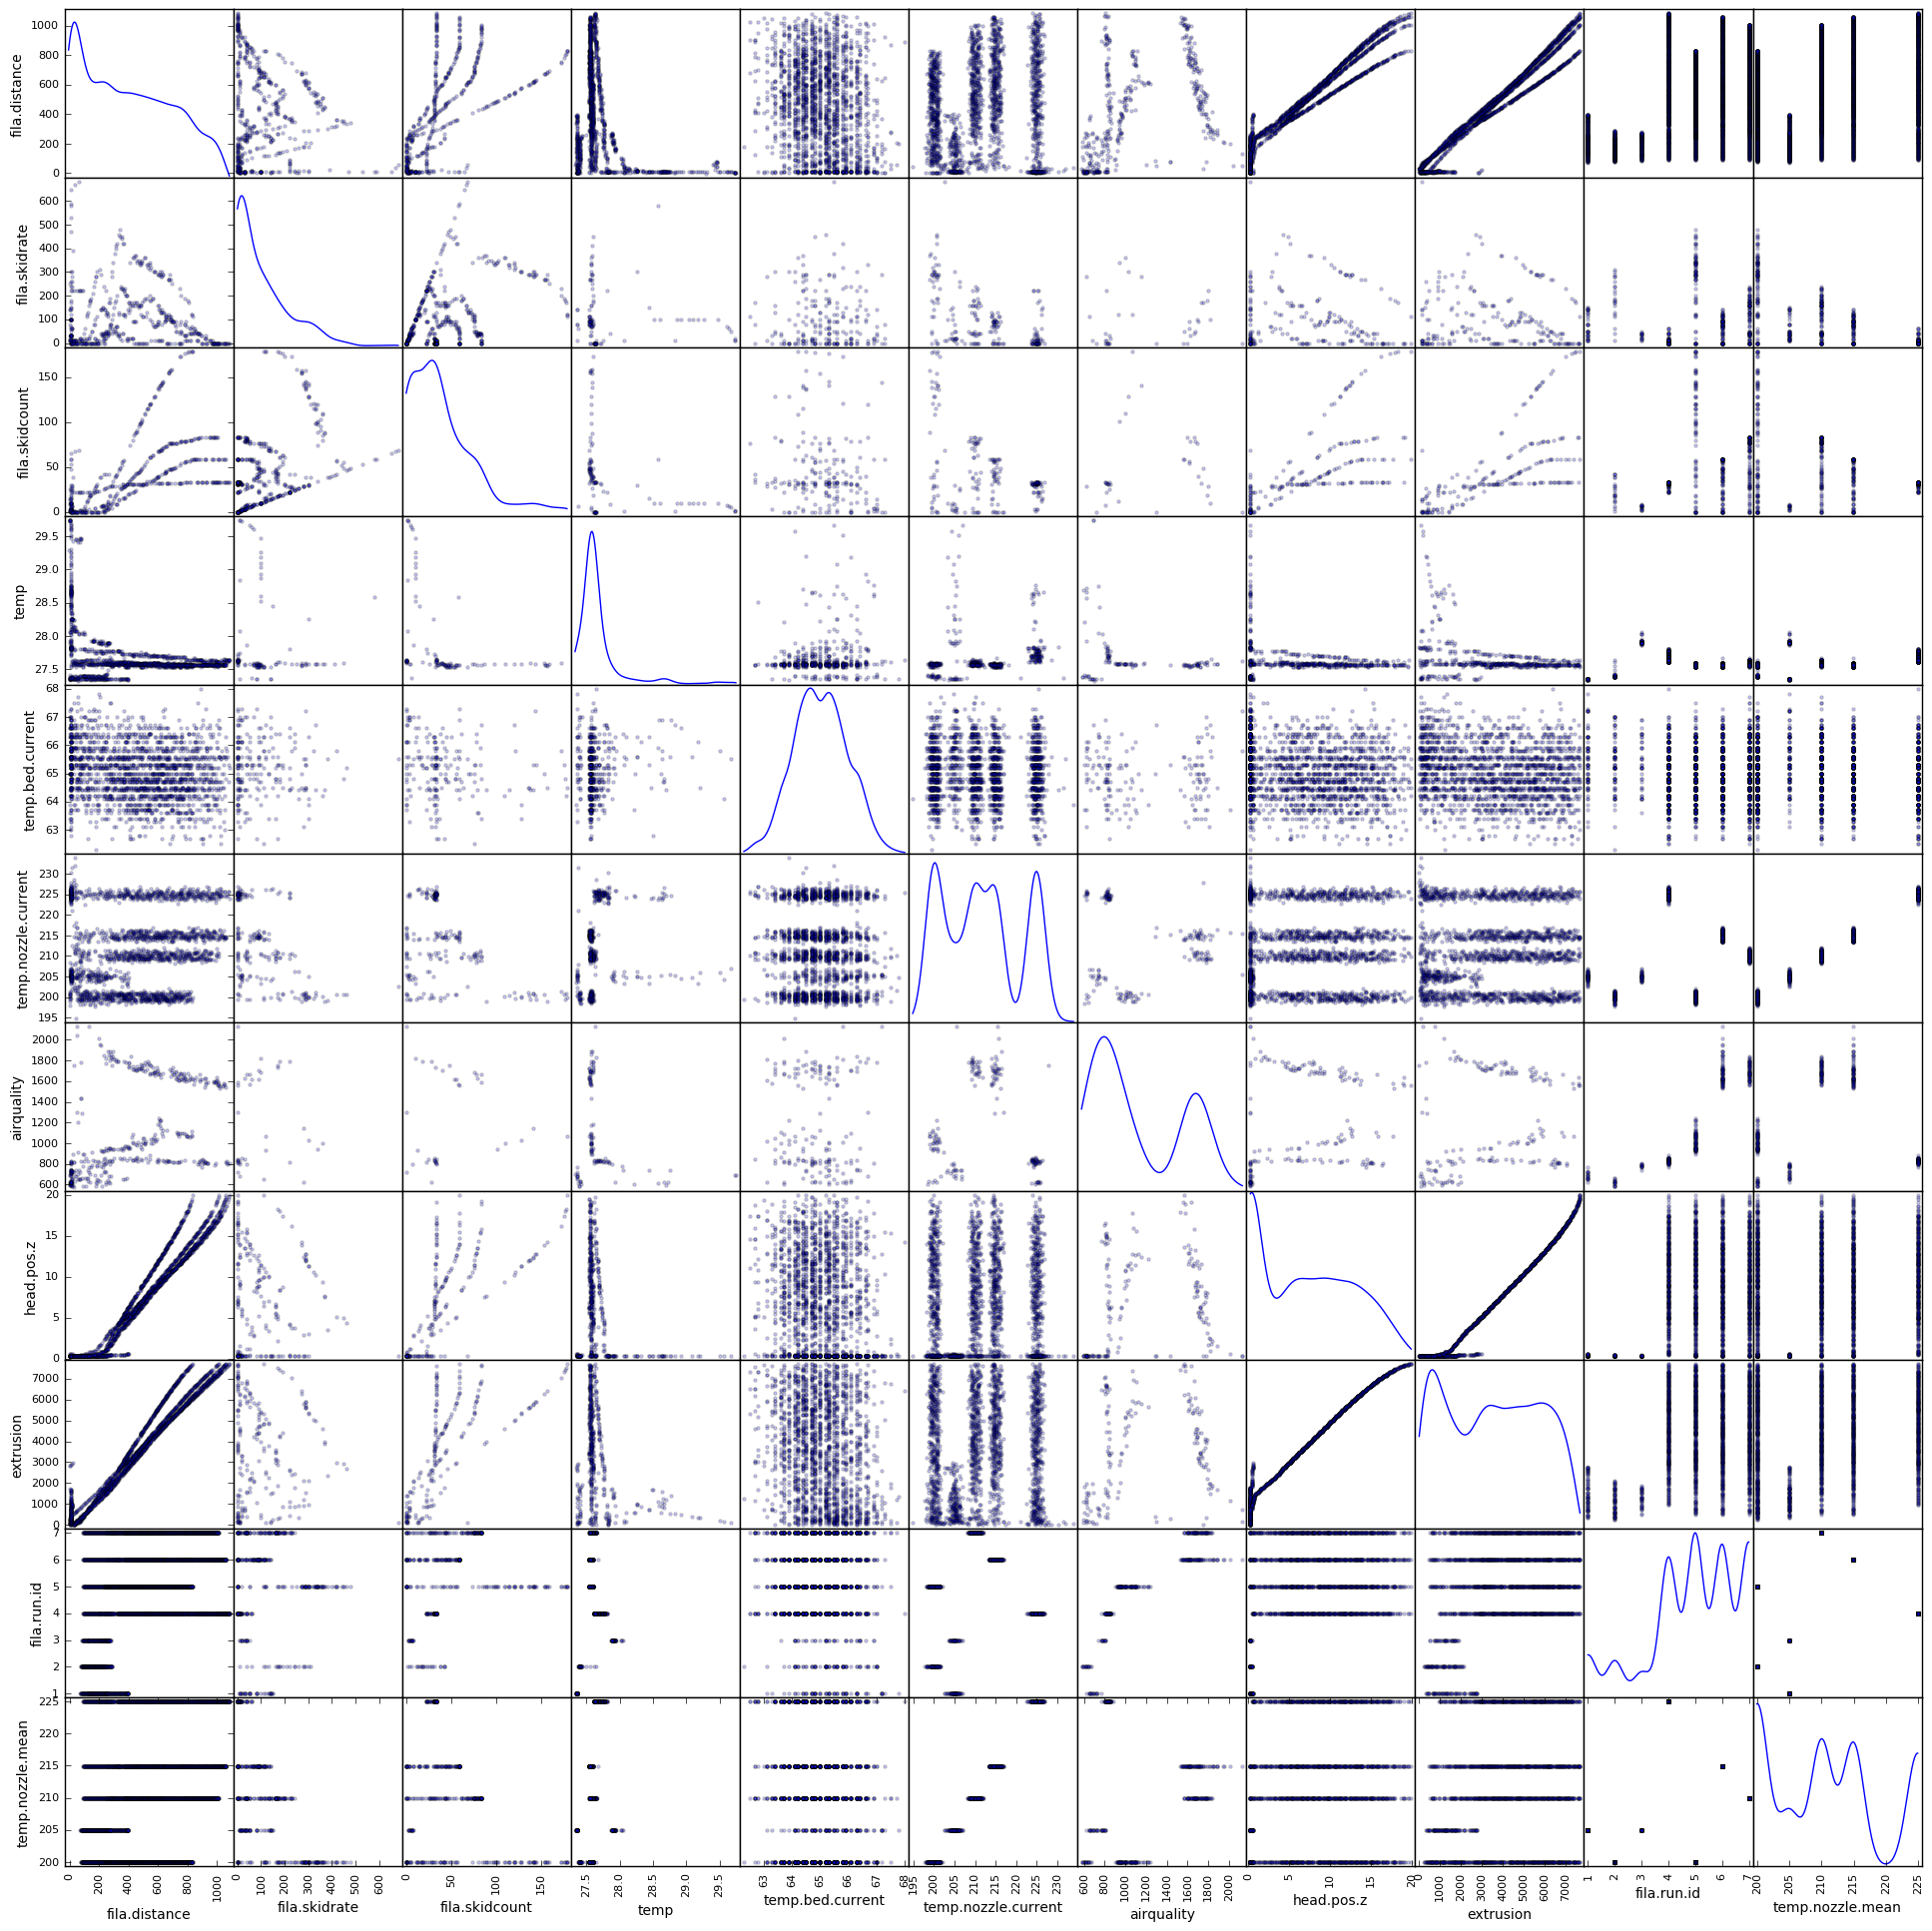

In [13]:
from pandas.tools.plotting import scatter_matrix

ax = scatter_matrix(df, alpha=0.2, figsize=(24, 24), diagonal='kde')
plt.savefig('./scatter_plot.png')
plt.show()

## Mask Sessions
In the following mask for each print are being generated.

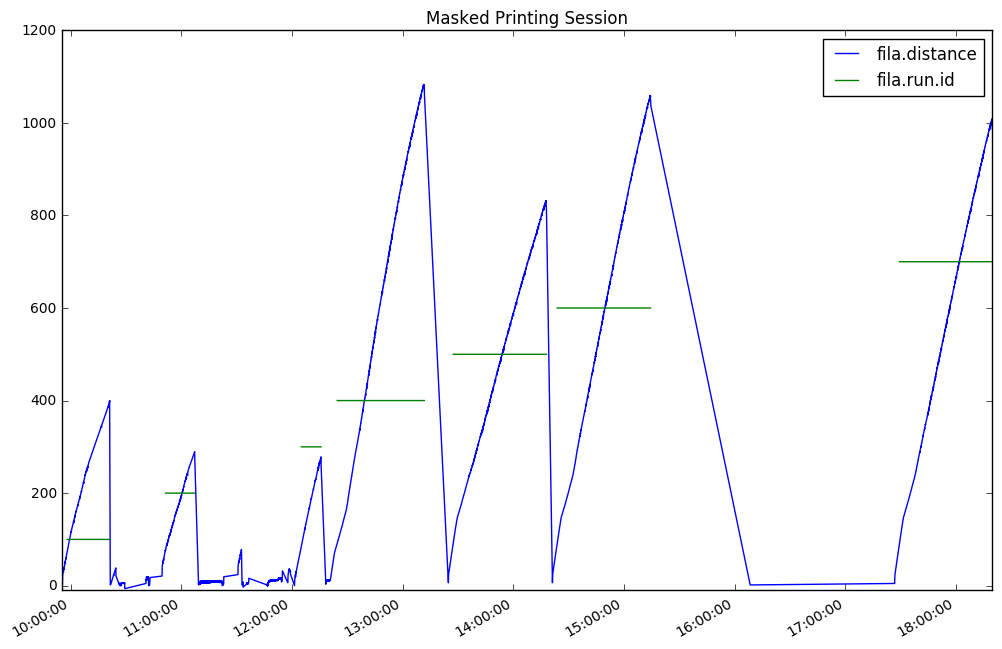

In [5]:
# create session mask and ids
fila_distance = df['fila.distance']
fila_run_id = mask_print_session(fila_distance)

# plot print sessions ids
diff_data = fila_distance.to_frame()
diff_data['fila.run.id'] = fila_run_id * 100 # make it visible in plot
diff_data.plot(figsize=(12, 8), ylim=[-10, 1200]# , style='x', 
#                xlim=[datetime.datetime(year=2016, month=12, day=23, hour=9, minute=55), 
#                      datetime.datetime(year=2016, month=12, day=23, hour=10, minute=55)]
              )

plt.title('Masked Printing Session')
plt.show()

# add to main dataframe
df['fila.run.id'] = fila_run_id

## Compute Mean Temperature
The mean temperature of the nozzle is computed for each print and added to the main dataframe.

Mean temp for print 1 is 204.94 C°
Mean temp for print 2 is 199.94 C°
Mean temp for print 3 is 205.02 C°
Mean temp for print 4 is 224.96 C°
Mean temp for print 5 is 200.01 C°
Mean temp for print 6 is 214.97 C°
Mean temp for print 7 is 210.00 C°


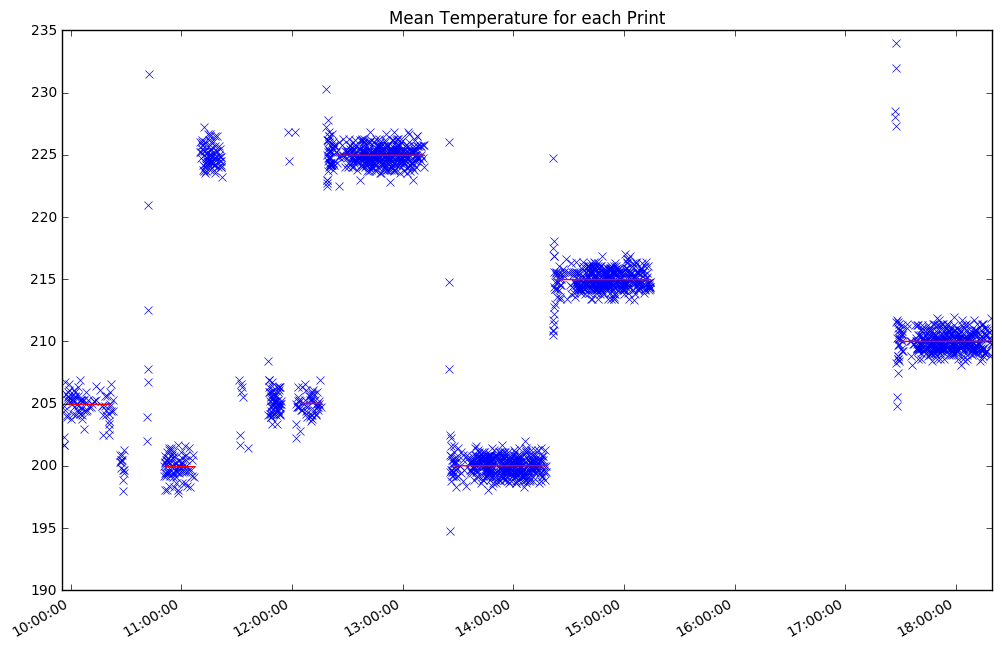

In [6]:
temp_mean = np.nan * np.ones(shape=len(fila_distance))
num_prints = int(df['fila.run.id'].max())
for session_id in range(1, num_prints+1):
    temp = df['temp.nozzle.current']
    ixs = np.array(df['fila.run.id'] == session_id, dtype=bool)
    temp_mean[ixs] = temp[ixs].mean()
    print('Mean temp for print {} is {:.2f} C°'.format(session_id, temp[ixs].mean()))
    
temp_mean = pd.Series(index=fila_distance.index, data=temp_mean)

df['temp.nozzle.current'].plot(style='x', figsize=(12, 8))
temp_mean.plot(style='r', figsize=(12, 8))
plt.title('Mean Temperature for each Print')
plt.show()

# add to main dataframe
df['temp.nozzle.mean'] = temp_mean

In [7]:
# store as csv
df.to_csv('printer_data_23_12_2016.csv', date_format='%s')
df.head()

,fila.distance,fila.skidrate,fila.skidcount,temp,temp.bed.current,temp.nozzle.current,airquality,head.pos.z,extrusion,fila.run.id,temp.nozzle.mean
2016-12-23 09:55:34,3.2,NaN,NaN,27.346001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-23 09:55:35,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-23 09:55:36,12.8,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-23 09:55:37,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-23 09:55:38,17.6,NaN,NaN,NaN,NaN,NaN,666.0,NaN,NaN,NaN,NaN


## Muliple Linear Regression Analysis

First NAN are interporlated. Afterwards multiple linear regression (MLR) is applied to predict skidrate.

Documentation:
- Interpolation: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.interpolate.html#pandas.Series.interpolate
- MLR: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

### Interpolate Missing Measurements for each Print

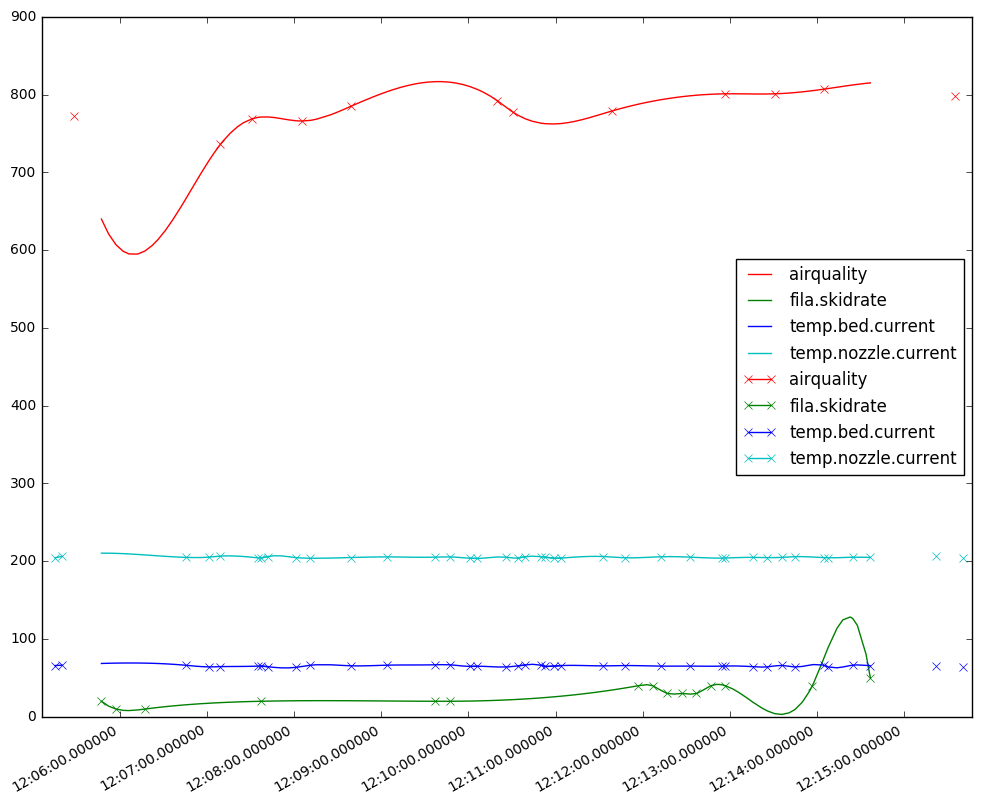

In [8]:
from statsmodels.api import OLS

# join data from each print
num_prints = int(df['fila.run.id'].max())
session_frames = []
indexes = []
for session_id in range(1, num_prints+1):
    ixs = np.array(df['fila.run.id'] == session_id, dtype=bool)
    indexes.append(ixs)

    # interpolate missing data points
    interpolated = df.loc[ixs].interpolate(method='cubic').dropna()
    
    session_frames.append(interpolated)
    
# plot interpolation
session_id = 2
sensors = ['airquality', 'fila.skidrate', 'temp.bed.current', 'temp.nozzle.current',]
ax = session_frames[session_id].ix[:, sensors].plot(figsize=(12, 10), color=['r', 'g', 'b', 'c'])
df.loc[indexes[session_id]].ix[:, sensors].plot(ax=ax, color=['r', 'g', 'b', 'c'], marker='x')
plt.show()

                            OLS Regression Results                            
Dep. Variable:          fila.skidrate   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     2384.
Date:                Thu, 16 Feb 2017   Prob (F-statistic):               0.00
Time:                        08:35:16   Log-Likelihood:                -22291.
No. Observations:                3882   AIC:                         4.460e+04
Df Residuals:                    3875   BIC:                         4.464e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
fila.distance          -0.6112    

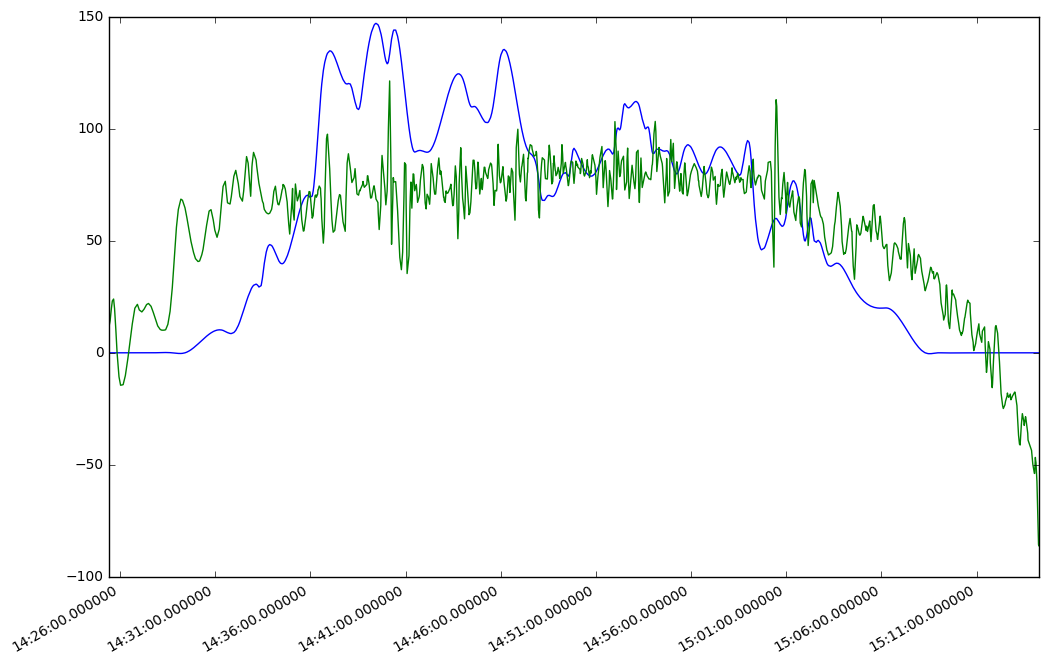

In [9]:
# concatenate dat from each printing session
session_frame = pd.concat(session_frames[:])

# define predictor variables
predictor_cols = [
                  # 'fila.skidrate',
                  'fila.distance',
                  # 'fila.skidcount',
                  'temp',
                  'temp.bed.current',
                  'temp.nozzle.current',
                  'airquality',
                  'head.pos.z', 
                  'extrusion',
#                   'fila.run.id',
#                   'temp.nozzle.mean'
                 ]
predictors = session_frame.ix[:, predictor_cols]  

# define latent variable
dependend_var = session_frame['fila.skidrate']

# fit model
model = OLS(dependend_var, predictors)
result = model.fit()
print (result.summary())

# predict data
predict_frame = session_frames[5]
X = predict_frame.ix[:, predictor_cols]
predicted = result.predict(X)

predict_frame['fila.skidrate'].plot(figsize=(12, 10))
predicted.plot(figsize=(12, 8))
plt.show()

# plot interpolated values
# interpolated.plot(figsize=(12, 10))
# plt.title('Meausurements of session {}'.format(session_id))
# plt.show()